# Heart Disease Classification

## Data Preprocessing

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [60]:
filename = 'heart_cleveland_upload.csv'
df = pd.read_csv(filename)

print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


In [61]:
# Show basic info
print(df.info())  # Check for missing values and data types
print(df.describe())  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    2.1

### Histograms

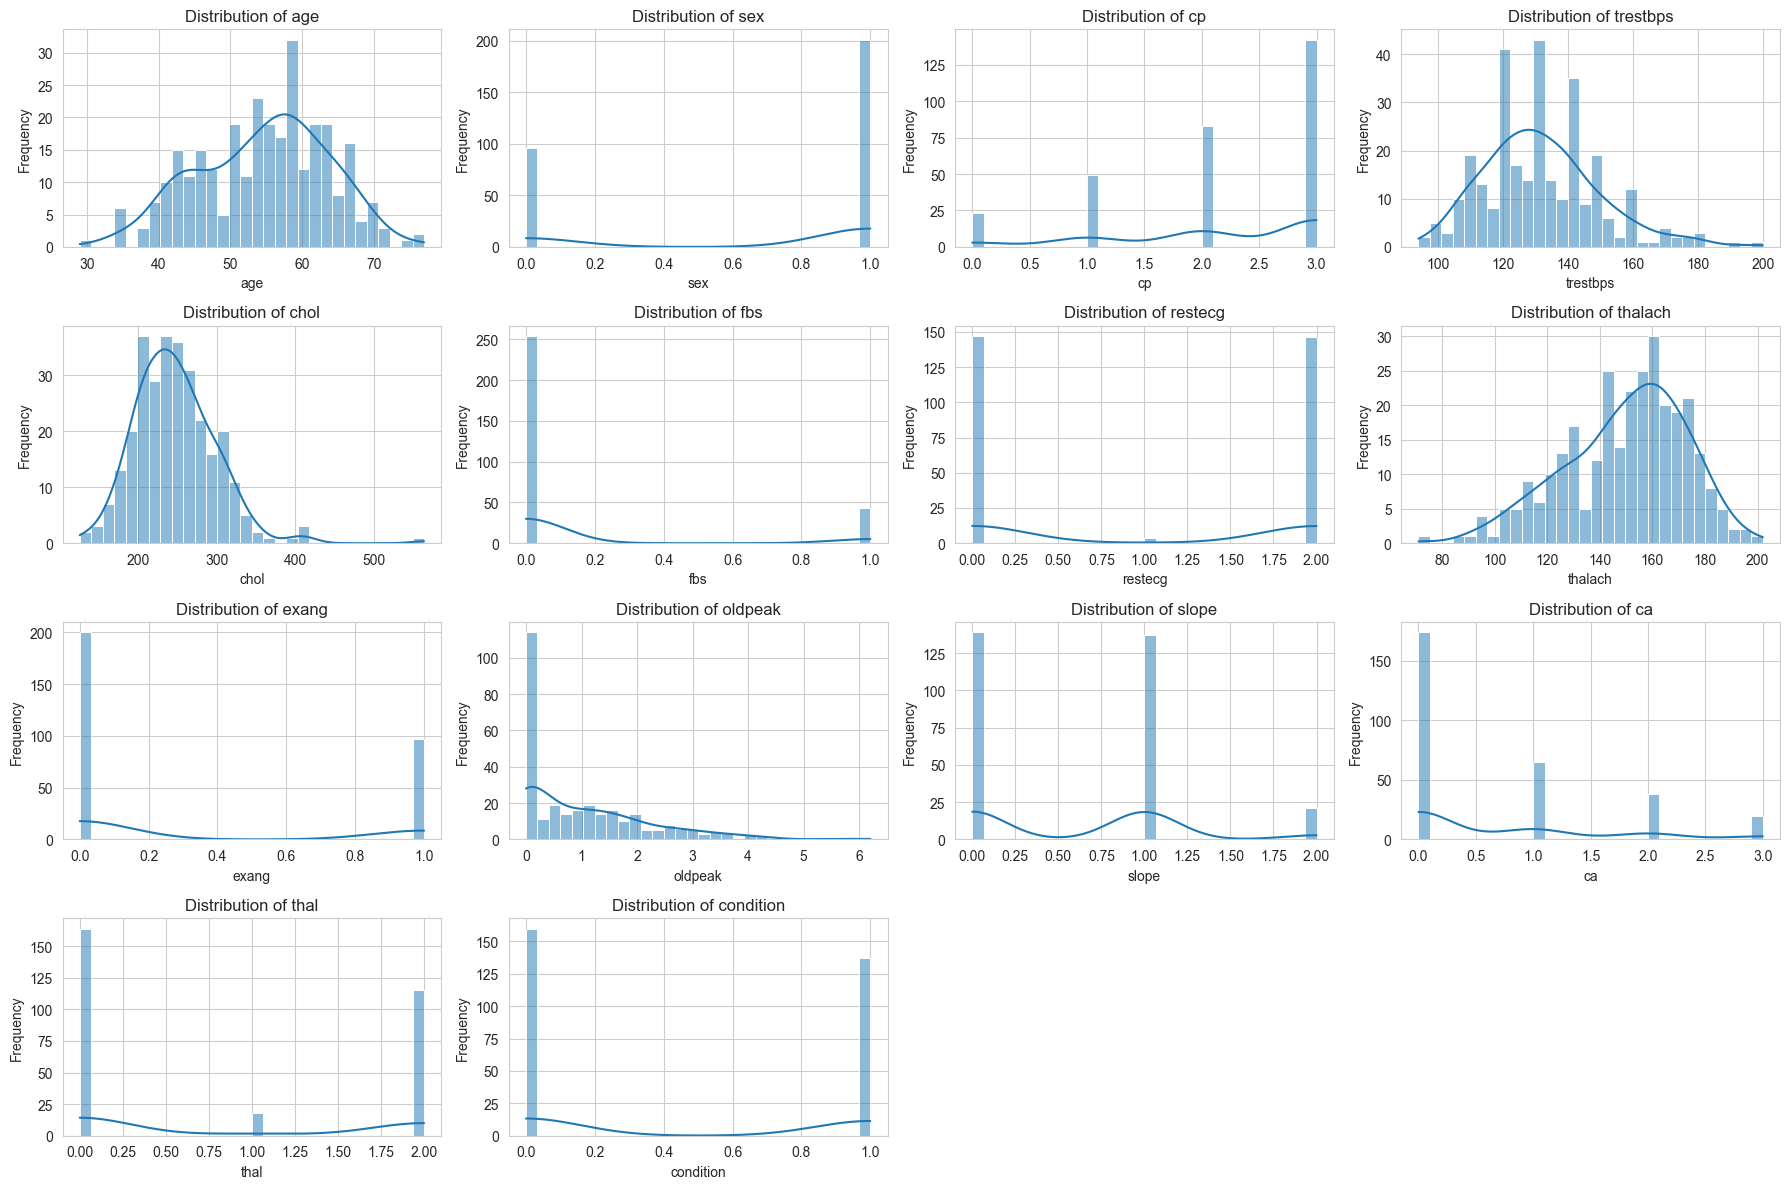

In [62]:
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [63]:
df = pd.get_dummies(df, drop_first=True)  # One-hot encoding

In [64]:
print(df['thal'])

0      0
1      0
2      0
3      0
4      0
      ..
292    2
293    2
294    2
295    0
296    2
Name: thal, Length: 297, dtype: int64


### Split data into Train and Test Set

In [65]:
# separate data from labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(X.head())
print()
print(y.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  
0   1     0  
1   2     0  
2   0     0  
3   1     0  
4   0     0  

0    0
1    0
2    0
3    1
4    0
Name: condition, dtype: int64


In [66]:
# Split data into train and test set: 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Split training data into train and validation set: 80:20
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [67]:
print(f"Training Set:       X_train={X_train.shape},    y_train={y_train.shape}")
# print(f"Validation Set:     X_val={X_val.shape},        y_val={y_val.shape}")
print(f"Test Set:           X_test={X_test.shape},      y_test={y_test.shape}")

Training Set:       X_train=(237, 13),    y_train=(237,)
Test Set:           X_test=(60, 13),      y_test=(60,)


## Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

### Grid search to find the best parameter C

In [69]:
log_reg = LogisticRegression(solver='liblinear', max_iter=300)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',
    verbose=1
)
grid_search.fit(X_train, y_train)
print("Best C from GridSearchCV:", grid_search.best_params_['C'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best C from GridSearchCV: 0.1


### Classification Report

In [70]:
best_model = grid_search.best_estimator_

preds = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.70      0.75      0.72        28

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



### Confusion Matrx

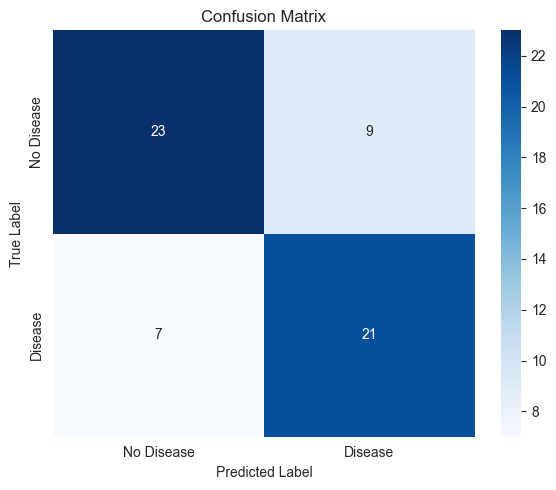

In [71]:
cm = confusion_matrix(y_test, preds)

labels = ['No Disease', 'Disease']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### ROC AUC

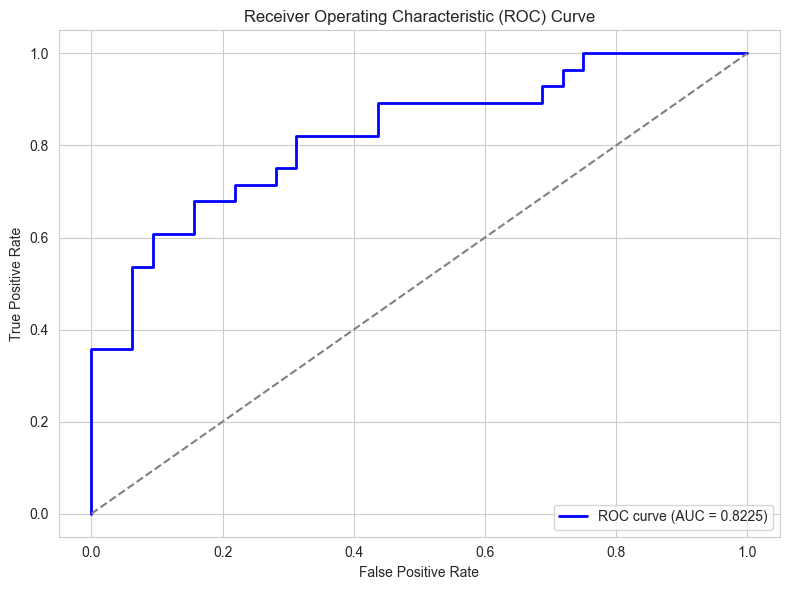

In [ ]:
probs = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

auc = roc_auc_score(y_test, probs)

plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()